In [1]:
from sknetwork.clustering import Louvain, modularity, PropagationClustering, KMeans
from sknetwork.visualization import svg_graph, svg_digraph, svg_bigraph
from IPython.display import SVG
from sknetwork.embedding import GSVD
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
from infomap import Infomap
import numpy as np

### Infomap

In [2]:
def Create_Dictionary(G):
    #Diccionarios para recordar nombres
    dicId={}
    dicUbigeo={}
    n=0
    for i in G.nodes():
        dicId[n]=i
        dicUbigeo[i]=n
        n=n+1
    return dicId, dicUbigeo

In [3]:
def Read_Map(uMapLevel):
    fp = uMapLevel
    gdf = gpd.read_file(fp)
    gdf = gdf.set_geometry("geometry")
    gdf = gdf.to_crs("EPSG:4326")
    return gdf

In [4]:
def Infomap_function(G):
    
    im = Infomap("--flow-model directed")
    # --num-trials 3
    for e in G.edges.data("weight", default=1):
        im.addLink(dicUbigeo[e[0]],dicUbigeo[e[1]],e[2])

    # Run the Infomap search algorithm to find optimal modules
    im.run()

    print("Cantidad de grupos:",im.num_top_modules)
    np.zeros((2,3,4),dtype=np.int16)

    labels=np.zeros(G.number_of_nodes(),dtype=np.int16)


    for node in im.tree:
        if node.is_leaf:
            labels[node.node_id]=int(node.module_id)
            #print(node.node_id, node.module_id)

    data=nx.adjacency_matrix(G)
    #print(data)
    mod=modularity(data, labels)
    print("La modularidad es", mod)
    
    return labels

In [5]:
def Draw_Map(gdf, labels, level):
    # Asignar el grupo a cada elemento del geo-dataframe
    
    for i in range(len(labels)):
        if(level=="dep"):
            gdf.loc[gdf.IDDPTO==dicId[i],'GRUPO']=int(labels[i])
        elif(level=="pro"):
            gdf.loc[gdf.IDPROV==dicId[i],'GRUPO']=int(labels[i])
        elif(level=="dis"):
            gdf.loc[gdf.IDDIST==dicId[i],'GRUPO']=int(labels[i])
    # Pintar el Perú según los grupos
    plt.figure(3,figsize=(8,8)) 
    gdf.plot("GRUPO",legend=True)
    #gdf.loc[gdf.IDDPTO=='15'].plot("GRUPO",legend=True)
    #plt.savefig('Figuras/Louvain_{}_{}.png'.format(level,modularity_function))

### Departamentos

Cantidad de grupos: 1
La modularidad es -2.220446049250313e-16


<Figure size 576x576 with 0 Axes>

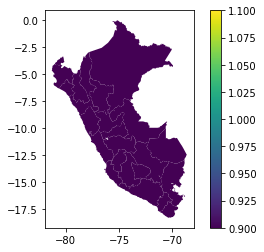

In [6]:
uGraph="grafoPeruDepartamentos.net"
uMapLevel="Datos/departamentos/DEPARTAMENTOS.shp"
level="dep"

G = nx.DiGraph(nx.read_pajek("Input/"+uGraph))
dicId, dicUbigeo = Create_Dictionary(G)
gdf = Read_Map(uMapLevel)
labels=Infomap_function(G)
Draw_Map(gdf, labels,level)

#Louvain
#Potts: 0.006913861987900449
#Newman: 0.01786312421880909
#Dugue: 0.04546689804513704 **

#Infomap
#TwoLevel: 0.02868281369032344
#MultiLevel: 0.02868281369032344

In [16]:
len(labels)

25

In [17]:
for i in dicId:
    if(len(gdf.loc[gdf.IDDPTO==dicId[i]])!=1):
        print(i, dicId[i], "\t", len(gdf.loc[gdf.IDDPTO==dicId[i]]))

### Provincias

Cantidad de grupos: 1
La modularidad es 0.0


<Figure size 576x576 with 0 Axes>

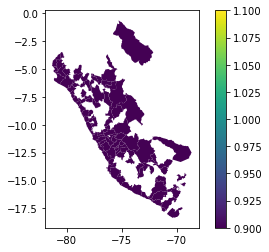

In [9]:
uGraph="grafoPeruProvincias_25.net"
uMapLevel="Datos/provincias/PROVINCIAS.shp"
level="pro"
modularity_function='dugue'

G = nx.DiGraph(nx.read_pajek("Input/"+uGraph))
dicId, dicUbigeo = Create_Dictionary(G)
gdf = Read_Map(uMapLevel)
labels=Infomap_function(G)
Draw_Map(gdf, labels,level)

#Louvain
#Potts: 0.003547246452094477
#Newman: 0.022254222428865877
#Louvain: 0.060224522628283594 **

#Infomap
#TwoLevel: 0.002807837739572605
#MultiLevel: 0.00038047137696284317

In [8]:
for i in dicId:
    if(len(gdf.loc[gdf.IDPROV==dicId[i]])!=1):
        print(i, dicId[i], "\t", len(gdf.loc[gdf.IDPROV==dicId[i]]))

### Distritos

Cantidad de grupos: 8
La modularidad es 0.0014138834110846155


<Figure size 576x576 with 0 Axes>

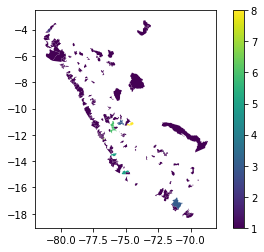

In [11]:
uGraph="grafoPeruDistritos_25.net"
uMapLevel="Datos/distritos/DISTRITOS.shp"
level="dis"
modularity_function='dugue'

G = nx.DiGraph(nx.read_pajek("Input/"+uGraph))
dicId, dicUbigeo = Create_Dictionary(G)
gdf = Read_Map(uMapLevel)
labels=Infomap_function(G)
Draw_Map(gdf, labels,level)

#Louvain
#Potts: 0.003467692702352254
#Newman: 0.14343007513175055
#Dugue: 0.15974494380607235 **

#Infomap
#TwoLevel: 0.0023964417141152383
#MultiLevel: 0.0023964417141152383

In [89]:

for i in dicId:
    if(len(gdf.loc[gdf.IDDIST==dicId[i]])!=1):
        print(i, dicId[i], "\t", len(gdf.loc[gdf.IDDIST==dicId[i]]))

812 090712 	 0
854 120606 	 0
1001 120604 	 0


In [64]:
gdf.loc[gdf.IDDIST=="120604"]

,IDDPTO,DEPARTAMEN,IDPROV,PROVINCIA,IDDIST,DISTRITO,CAPITAL,CODCCPP,AREA,FUENTE,geometry,GRUPO


In [67]:
dicId["120604"]

1001